## Import Tensorflow Libraries

In [165]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Create our Training Dataset and Validation Dataset

In [129]:
#Test Dataset with flowers to test our model
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [166]:
data_dir = "nvme_drive/Training Data"
AUTOTUNE = tf.data.AUTOTUNE

batch_size = 64
img_height = 240
img_width = 240

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)




val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(train_ds.class_names)
print(class_names)
print("Number of classes found: " + str(num_classes))

Found 3790 files belonging to 3 classes.
Using 3032 files for training.
Found 3790 files belonging to 3 classes.
Using 758 files for validation.
['Hitler Sorted', 'None', 'Swastika']
Number of classes found: 3


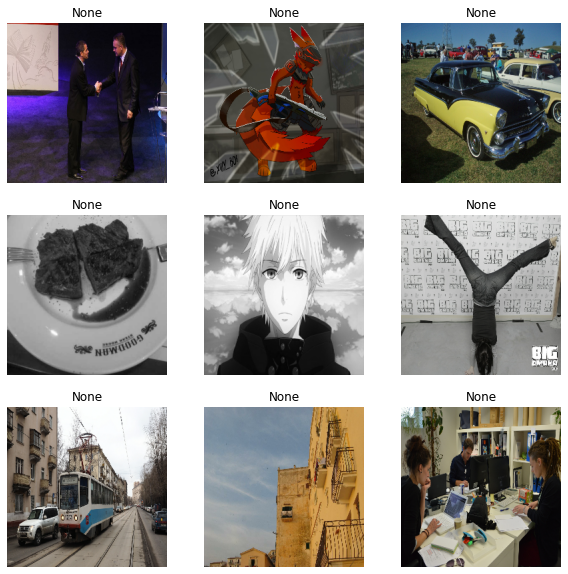

In [167]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Create Model

### Preprocessing our Data

In [132]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

#Data augmentation should only be applied to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

In [168]:
#Buffered prefetching applied to all datasets
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Set and Compile the model

In [169]:
#model = tf.keras.applications.resnet50.ResNet50(weights = None, input_shape = (img_width, img_height ,3), classes=num_classes)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])



model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_39 (Sequential)  (None, 240, 240, 3)       0         
                                                                 
 rescaling_22 (Rescaling)    (None, 240, 240, 3)       0         
                                                                 
 conv2d_66 (Conv2D)          (None, 240, 240, 16)      448       
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 120, 120, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 60, 60, 32)       0         
 g2D)                                                

## Train the Model

In [170]:
epochs=64
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/64
26/48 [===============>..............] - ETA: 1s - loss: 0.1909 - accuracy: 0.9808

2022-08-20 22:08:12.250246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.1584 - accuracy: 0.9831

2022-08-20 22:08:13.404198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 6s 107ms/step - loss: 0.1299 - accuracy: 0.9861 - val_loss: 0.0728 - val_accuracy: 0.9921
Epoch 2/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0542 - accuracy: 0.9886

2022-08-20 22:08:18.002171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0486 - accuracy: 0.9899

2022-08-20 22:08:19.094180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 99ms/step - loss: 0.0446 - accuracy: 0.9901 - val_loss: 0.0324 - val_accuracy: 0.9894
Epoch 3/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0311 - accuracy: 0.9910

2022-08-20 22:08:23.323721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0325 - accuracy: 0.9911

2022-08-20 22:08:24.389560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 97ms/step - loss: 0.0288 - accuracy: 0.9924 - val_loss: 0.0245 - val_accuracy: 0.9921
Epoch 4/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0284 - accuracy: 0.9916

2022-08-20 22:08:28.591303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0224 - accuracy: 0.9924

2022-08-20 22:08:29.653731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0212 - accuracy: 0.9934 - val_loss: 0.0292 - val_accuracy: 0.9908
Epoch 5/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0214 - accuracy: 0.9940

2022-08-20 22:08:33.931313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0156 - accuracy: 0.9958

2022-08-20 22:08:35.043514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 99ms/step - loss: 0.0227 - accuracy: 0.9951 - val_loss: 0.0240 - val_accuracy: 0.9908
Epoch 6/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0267 - accuracy: 0.9928

2022-08-20 22:08:39.353925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0210 - accuracy: 0.9937

2022-08-20 22:08:40.407864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0251 - accuracy: 0.9931 - val_loss: 0.0357 - val_accuracy: 0.9908
Epoch 7/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0238 - accuracy: 0.9946

2022-08-20 22:08:44.704429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0217 - accuracy: 0.9949

2022-08-20 22:08:45.810250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 100ms/step - loss: 0.0208 - accuracy: 0.9951 - val_loss: 0.0236 - val_accuracy: 0.9908
Epoch 8/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0236 - accuracy: 0.9928

2022-08-20 22:08:50.103704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0228 - accuracy: 0.9932

2022-08-20 22:08:51.210557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 99ms/step - loss: 0.0210 - accuracy: 0.9941 - val_loss: 0.0287 - val_accuracy: 0.9908
Epoch 9/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0198 - accuracy: 0.9934

2022-08-20 22:08:55.434448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0243 - accuracy: 0.9928

2022-08-20 22:08:56.530362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0249 - accuracy: 0.9934 - val_loss: 0.0353 - val_accuracy: 0.9908
Epoch 10/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0299 - accuracy: 0.9934

2022-08-20 22:09:00.835676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0272 - accuracy: 0.9937

2022-08-20 22:09:01.914212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 99ms/step - loss: 0.0234 - accuracy: 0.9947 - val_loss: 0.0229 - val_accuracy: 0.9947
Epoch 11/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0210 - accuracy: 0.9952

2022-08-20 22:09:06.177913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0226 - accuracy: 0.9954

2022-08-20 22:09:07.269954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0198 - accuracy: 0.9954 - val_loss: 0.0276 - val_accuracy: 0.9908
Epoch 12/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0234 - accuracy: 0.9928

2022-08-20 22:09:11.462781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0219 - accuracy: 0.9937

2022-08-20 22:09:12.503081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 97ms/step - loss: 0.0201 - accuracy: 0.9944 - val_loss: 0.0282 - val_accuracy: 0.9934
Epoch 13/64
27/48 [===============>..............] - ETA: 1s - loss: 0.0243 - accuracy: 0.9936

2022-08-20 22:09:16.820801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0201 - accuracy: 0.9945

2022-08-20 22:09:17.913525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 99ms/step - loss: 0.0183 - accuracy: 0.9954 - val_loss: 0.0274 - val_accuracy: 0.9908
Epoch 14/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0188 - accuracy: 0.9970

2022-08-20 22:09:22.192976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0172 - accuracy: 0.9962

2022-08-20 22:09:23.271570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0163 - accuracy: 0.9964 - val_loss: 0.0289 - val_accuracy: 0.9908
Epoch 15/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0209 - accuracy: 0.9940

2022-08-20 22:09:27.453102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0183 - accuracy: 0.9949

2022-08-20 22:09:28.560287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 97ms/step - loss: 0.0161 - accuracy: 0.9957 - val_loss: 0.0308 - val_accuracy: 0.9908
Epoch 16/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0119 - accuracy: 0.9952

2022-08-20 22:09:32.899679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0139 - accuracy: 0.9954

2022-08-20 22:09:33.969618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 100ms/step - loss: 0.0152 - accuracy: 0.9957 - val_loss: 0.0266 - val_accuracy: 0.9908
Epoch 17/64
25/48 [==============>...............] - ETA: 1s - loss: 0.0167 - accuracy: 0.9944

2022-08-20 22:09:38.249323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0171 - accuracy: 0.9954

2022-08-20 22:09:39.300158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0163 - accuracy: 0.9957 - val_loss: 0.0255 - val_accuracy: 0.9921
Epoch 18/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0206 - accuracy: 0.9946

2022-08-20 22:09:43.554766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0219 - accuracy: 0.9954

2022-08-20 22:09:44.611270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0233 - accuracy: 0.9951 - val_loss: 0.0254 - val_accuracy: 0.9934
Epoch 19/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0219 - accuracy: 0.9940

2022-08-20 22:09:48.924988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0174 - accuracy: 0.9949

2022-08-20 22:09:50.005237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 99ms/step - loss: 0.0150 - accuracy: 0.9957 - val_loss: 0.0339 - val_accuracy: 0.9921
Epoch 20/64
27/48 [===============>..............] - ETA: 1s - loss: 0.0208 - accuracy: 0.9948

2022-08-20 22:09:54.290981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0173 - accuracy: 0.9954

2022-08-20 22:09:55.363511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0143 - accuracy: 0.9960 - val_loss: 0.0290 - val_accuracy: 0.9908
Epoch 21/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0152 - accuracy: 0.9970

2022-08-20 22:09:59.563508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0118 - accuracy: 0.9979

2022-08-20 22:10:00.646094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0163 - accuracy: 0.9970 - val_loss: 0.0266 - val_accuracy: 0.9934
Epoch 22/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0183 - accuracy: 0.9964

2022-08-20 22:10:04.964086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0149 - accuracy: 0.9966

2022-08-20 22:10:06.057579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0134 - accuracy: 0.9964 - val_loss: 0.0277 - val_accuracy: 0.9934
Epoch 23/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0225 - accuracy: 0.9940

2022-08-20 22:10:10.233547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0194 - accuracy: 0.9954

2022-08-20 22:10:11.317735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 97ms/step - loss: 0.0181 - accuracy: 0.9954 - val_loss: 0.0309 - val_accuracy: 0.9947
Epoch 24/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0149 - accuracy: 0.9958

2022-08-20 22:10:15.577325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0148 - accuracy: 0.9966

2022-08-20 22:10:16.668354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0119 - accuracy: 0.9974 - val_loss: 0.0306 - val_accuracy: 0.9947
Epoch 25/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0159 - accuracy: 0.9958

2022-08-20 22:10:20.890382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0171 - accuracy: 0.9962

2022-08-20 22:10:21.998669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 100ms/step - loss: 0.0156 - accuracy: 0.9960 - val_loss: 0.0272 - val_accuracy: 0.9947
Epoch 26/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0164 - accuracy: 0.9964

2022-08-20 22:10:26.359055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0132 - accuracy: 0.9970

2022-08-20 22:10:27.462604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 99ms/step - loss: 0.0119 - accuracy: 0.9970 - val_loss: 0.0330 - val_accuracy: 0.9921
Epoch 27/64
25/48 [==============>...............] - ETA: 1s - loss: 0.0103 - accuracy: 0.9969

2022-08-20 22:10:31.616395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0110 - accuracy: 0.9975

2022-08-20 22:10:32.691569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 97ms/step - loss: 0.0090 - accuracy: 0.9980 - val_loss: 0.0340 - val_accuracy: 0.9947
Epoch 28/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0143 - accuracy: 0.9970

2022-08-20 22:10:36.940165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0117 - accuracy: 0.9975

2022-08-20 22:10:38.049882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 99ms/step - loss: 0.0094 - accuracy: 0.9980 - val_loss: 0.0500 - val_accuracy: 0.9921
Epoch 29/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0133 - accuracy: 0.9964

2022-08-20 22:10:42.367722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0106 - accuracy: 0.9970

2022-08-20 22:10:43.484026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 100ms/step - loss: 0.0117 - accuracy: 0.9974 - val_loss: 0.0283 - val_accuracy: 0.9947
Epoch 30/64
27/48 [===============>..............] - ETA: 1s - loss: 0.0089 - accuracy: 0.9971

2022-08-20 22:10:47.746761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0123 - accuracy: 0.9970

2022-08-20 22:10:48.823226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0104 - accuracy: 0.9974 - val_loss: 0.0281 - val_accuracy: 0.9947
Epoch 31/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0141 - accuracy: 0.9958

2022-08-20 22:10:53.105578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0115 - accuracy: 0.9970

2022-08-20 22:10:54.193250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 99ms/step - loss: 0.0097 - accuracy: 0.9974 - val_loss: 0.0385 - val_accuracy: 0.9947
Epoch 32/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0160 - accuracy: 0.9952

2022-08-20 22:10:58.514646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0140 - accuracy: 0.9954

2022-08-20 22:10:59.631574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 100ms/step - loss: 0.0114 - accuracy: 0.9964 - val_loss: 0.0264 - val_accuracy: 0.9947
Epoch 33/64
27/48 [===============>..............] - ETA: 1s - loss: 0.0155 - accuracy: 0.9965

2022-08-20 22:11:03.936054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0121 - accuracy: 0.9975

2022-08-20 22:11:04.995084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0098 - accuracy: 0.9980 - val_loss: 0.0370 - val_accuracy: 0.9947
Epoch 34/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0165 - accuracy: 0.9970

2022-08-20 22:11:09.334638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0220 - accuracy: 0.9962

2022-08-20 22:11:10.433130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 99ms/step - loss: 0.0175 - accuracy: 0.9970 - val_loss: 0.0236 - val_accuracy: 0.9947
Epoch 35/64
25/48 [==============>...............] - ETA: 1s - loss: 0.0182 - accuracy: 0.9969

2022-08-20 22:11:14.689209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0139 - accuracy: 0.9975

2022-08-20 22:11:15.766637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0111 - accuracy: 0.9980 - val_loss: 0.0349 - val_accuracy: 0.9947
Epoch 36/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0095 - accuracy: 0.9976

2022-08-20 22:11:19.977569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0119 - accuracy: 0.9979

2022-08-20 22:11:21.050441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0110 - accuracy: 0.9980 - val_loss: 0.0281 - val_accuracy: 0.9947
Epoch 37/64
25/48 [==============>...............] - ETA: 1s - loss: 0.0112 - accuracy: 0.9969

2022-08-20 22:11:25.328116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0094 - accuracy: 0.9975

2022-08-20 22:11:26.443488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 99ms/step - loss: 0.0075 - accuracy: 0.9980 - val_loss: 0.0704 - val_accuracy: 0.9921
Epoch 38/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0115 - accuracy: 0.9964

2022-08-20 22:11:30.642014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0133 - accuracy: 0.9966

2022-08-20 22:11:31.748551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 97ms/step - loss: 0.0158 - accuracy: 0.9967 - val_loss: 0.0319 - val_accuracy: 0.9947
Epoch 39/64
27/48 [===============>..............] - ETA: 1s - loss: 0.0112 - accuracy: 0.9971

2022-08-20 22:11:35.982710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0095 - accuracy: 0.9979

2022-08-20 22:11:37.067850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0097 - accuracy: 0.9980 - val_loss: 0.0340 - val_accuracy: 0.9947
Epoch 40/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0088 - accuracy: 0.9976

2022-08-20 22:11:41.353663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0080 - accuracy: 0.9979

2022-08-20 22:11:42.444138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 99ms/step - loss: 0.0090 - accuracy: 0.9980 - val_loss: 0.0366 - val_accuracy: 0.9947
Epoch 41/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0054 - accuracy: 0.9982

2022-08-20 22:11:46.723505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0070 - accuracy: 0.9983

2022-08-20 22:11:47.831970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 100ms/step - loss: 0.0073 - accuracy: 0.9984 - val_loss: 0.0417 - val_accuracy: 0.9947
Epoch 42/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0099 - accuracy: 0.9970

2022-08-20 22:11:52.141214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0081 - accuracy: 0.9975

2022-08-20 22:11:53.213608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0075 - accuracy: 0.9977 - val_loss: 0.0351 - val_accuracy: 0.9947
Epoch 43/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0066 - accuracy: 0.9982

2022-08-20 22:11:57.435878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0078 - accuracy: 0.9975

2022-08-20 22:11:58.530926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0072 - accuracy: 0.9977 - val_loss: 0.0326 - val_accuracy: 0.9947
Epoch 44/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0069 - accuracy: 0.9982

2022-08-20 22:12:02.865430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0060 - accuracy: 0.9979

2022-08-20 22:12:03.976871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 100ms/step - loss: 0.0056 - accuracy: 0.9980 - val_loss: 0.0452 - val_accuracy: 0.9947
Epoch 45/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0067 - accuracy: 0.9970

2022-08-20 22:12:08.175198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0093 - accuracy: 0.9975

2022-08-20 22:12:09.255889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0126 - accuracy: 0.9974 - val_loss: 0.0350 - val_accuracy: 0.9947
Epoch 46/64
27/48 [===============>..............] - ETA: 1s - loss: 0.0154 - accuracy: 0.9954

2022-08-20 22:12:13.509586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0118 - accuracy: 0.9966

2022-08-20 22:12:14.588097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0131 - accuracy: 0.9967 - val_loss: 0.0330 - val_accuracy: 0.9947
Epoch 47/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0132 - accuracy: 0.9982

2022-08-20 22:12:18.869016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0114 - accuracy: 0.9979

2022-08-20 22:12:19.978653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 99ms/step - loss: 0.0092 - accuracy: 0.9984 - val_loss: 0.0351 - val_accuracy: 0.9947
Epoch 48/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0098 - accuracy: 0.9976

2022-08-20 22:12:24.195732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0073 - accuracy: 0.9983

2022-08-20 22:12:25.257607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 97ms/step - loss: 0.0106 - accuracy: 0.9980 - val_loss: 0.0319 - val_accuracy: 0.9934
Epoch 49/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0092 - accuracy: 0.9988

2022-08-20 22:12:29.484296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0140 - accuracy: 0.9979

2022-08-20 22:12:30.578943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0161 - accuracy: 0.9970 - val_loss: 0.0435 - val_accuracy: 0.9934
Epoch 50/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0242 - accuracy: 0.9958

2022-08-20 22:12:34.770253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0186 - accuracy: 0.9966

2022-08-20 22:12:35.882837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0151 - accuracy: 0.9970 - val_loss: 0.0528 - val_accuracy: 0.9921
Epoch 51/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0157 - accuracy: 0.9958

2022-08-20 22:12:40.087590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0114 - accuracy: 0.9970

2022-08-20 22:12:41.182136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 97ms/step - loss: 0.0102 - accuracy: 0.9974 - val_loss: 0.0394 - val_accuracy: 0.9947
Epoch 52/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0073 - accuracy: 0.9982

2022-08-20 22:12:45.431032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0056 - accuracy: 0.9987

2022-08-20 22:12:46.534519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 99ms/step - loss: 0.0091 - accuracy: 0.9984 - val_loss: 0.0454 - val_accuracy: 0.9868
Epoch 53/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0206 - accuracy: 0.9970

2022-08-20 22:12:50.772775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0176 - accuracy: 0.9975

2022-08-20 22:12:51.851420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 97ms/step - loss: 0.0142 - accuracy: 0.9980 - val_loss: 0.0363 - val_accuracy: 0.9947
Epoch 54/64
27/48 [===============>..............] - ETA: 1s - loss: 0.0105 - accuracy: 0.9977

2022-08-20 22:12:56.120119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0091 - accuracy: 0.9975

2022-08-20 22:12:57.163054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0074 - accuracy: 0.9980 - val_loss: 0.0418 - val_accuracy: 0.9947
Epoch 55/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0088 - accuracy: 0.9988

2022-08-20 22:13:01.438771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0074 - accuracy: 0.9987

2022-08-20 22:13:02.529223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0064 - accuracy: 0.9987 - val_loss: 0.0411 - val_accuracy: 0.9947
Epoch 56/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0046 - accuracy: 0.9994

2022-08-20 22:13:06.797043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0037 - accuracy: 0.9996

2022-08-20 22:13:07.873693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 97ms/step - loss: 0.0043 - accuracy: 0.9993 - val_loss: 0.0359 - val_accuracy: 0.9934
Epoch 57/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0074 - accuracy: 0.9976

2022-08-20 22:13:12.148682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0061 - accuracy: 0.9983

2022-08-20 22:13:13.197924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0059 - accuracy: 0.9984 - val_loss: 0.0415 - val_accuracy: 0.9934
Epoch 58/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0062 - accuracy: 0.9982

2022-08-20 22:13:17.445198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0076 - accuracy: 0.9979

2022-08-20 22:13:18.541903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0065 - accuracy: 0.9984 - val_loss: 0.0449 - val_accuracy: 0.9947
Epoch 59/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0054 - accuracy: 0.9982

2022-08-20 22:13:22.788190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0057 - accuracy: 0.9983

2022-08-20 22:13:23.891835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0082 - accuracy: 0.9980 - val_loss: 0.0341 - val_accuracy: 0.9908
Epoch 60/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0050 - accuracy: 0.9976

2022-08-20 22:13:28.124418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0038 - accuracy: 0.9983

2022-08-20 22:13:29.191228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0031 - accuracy: 0.9987 - val_loss: 0.0414 - val_accuracy: 0.9947
Epoch 61/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0106 - accuracy: 0.9976

2022-08-20 22:13:33.465165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0089 - accuracy: 0.9979

2022-08-20 22:13:34.563175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 99ms/step - loss: 0.0074 - accuracy: 0.9984 - val_loss: 0.0473 - val_accuracy: 0.9947
Epoch 62/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0047 - accuracy: 0.9988

2022-08-20 22:13:38.824132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0036 - accuracy: 0.9992

2022-08-20 22:13:39.940500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 99ms/step - loss: 0.0051 - accuracy: 0.9990 - val_loss: 0.0416 - val_accuracy: 0.9934
Epoch 63/64
26/48 [===============>..............] - ETA: 1s - loss: 0.0015 - accuracy: 0.9994

2022-08-20 22:13:44.185301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0030 - accuracy: 0.9992

2022-08-20 22:13:45.261504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 98ms/step - loss: 0.0028 - accuracy: 0.9990 - val_loss: 0.0432 - val_accuracy: 0.9934
Epoch 64/64
27/48 [===============>..............] - ETA: 1s - loss: 0.0079 - accuracy: 0.9977

2022-08-20 22:13:49.530029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


37/48 [======================>.......] - ETA: 0s - loss: 0.0059 - accuracy: 0.9983

2022-08-20 22:13:50.619798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/48 [==============================] - 5s 99ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.0446 - val_accuracy: 0.9934


## Get Training Results

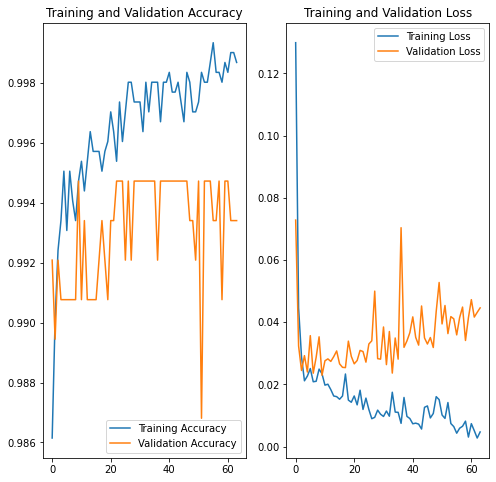

In [171]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Test Our Model

In [176]:
sunflower_url = "https://assets.deutschlandfunk.de/FILE_20548b6a9c73abd130413930c1b55a85/original.jpg?t=1597503481747"
sunflower_path = tf.keras.utils.get_file('1231111111', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 12ms/step
This image most likely belongs to None with a 100.00 percent confidence.


## Save our Dataset

In [177]:
import time

timestr = time.strftime("%Y%m%d-%H%M%S")
model.save("nvme_drive/Trained Models/" + timestr + "-SafetyNet", save_format="h5")